# VaR and ES notebook

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

raw = yf.download("^GSPC", start='1980-01-01', end='2024-12-31')
raw.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1980-01-02,105.760002,108.430000,105.290001,0.0,40610000
1980-01-03,105.220001,106.080002,103.260002,0.0,50480000
1980-01-04,106.519997,107.080002,105.089996,0.0,39130000
1980-01-07,106.809998,107.800003,105.800003,0.0,44500000
1980-01-08,108.949997,109.290001,106.290001,0.0,53390000


In [2]:
returns = raw.Close["^GSPC"].diff().dropna()
conf = .95

def normalVaR(mu, sigma, conf):
    return mu + sigma * scipy.stats.norm.ppf(1-conf)

normalVaR(np.mean(returns), np.std(returns), .95)

-32.21043951619077

In [3]:
scipy.stats.norm.ppf(1-.95, np.mean(returns), np.std(returns))

-32.21043951619077

In [4]:
def normalCVaR(mu, sigma, conf):
    return mu - sigma * scipy.stats.norm.pdf(scipy.stats.norm.ppf(conf)) / (1-conf)

normalCVaR(np.mean(returns), np.std(returns), .95)

-40.52311515074122

In [5]:
1/(1-.95) * scipy.integrate.quad(lambda x : x * scipy.stats.norm.pdf(x, loc=np.mean(returns), scale=np.std(returns)),
                     -np.inf,
                     scipy.stats.norm.ppf(1-.95, np.mean(returns), np.std(returns)))[0]

-40.523115150734064

## VaR

For a given confidence level $\alpha\in(0,1)$ and timeframe, VaR measures the maximum loss such that $(1-\alpha)\%$ of the time, the loss will be greater than the VaR. Mathematically, VaR is the $(1-\alpha)$-quantile loss, or:
$$
\text{VaR}_\alpha=F_X^{-1}(1-\alpha),
$$
where $F_X^{-1}(\cdot)$ is the inverse cumulative distribution function of the random variable $X$ of returns. Under the assumption that returns (equivalently, negative losses) are normally distributed under $X\sim\mathcal{N}(\mu,\sigma^2)$, the VaR is:
$$
\text{VaR}_\alpha = \mu + \sigma\cdot F^{-1}(1-\alpha),
$$
where $F^{-1}(\cdot)$ is the inverse cumulative distribution function of the standard normal.

Calculating historical VaR is therefore as simple as using the empirical distribution to find the value at which $(1-\alpha)\%$ of the returns lie below:

VaR: -25.21; VaR under normality: -32.21


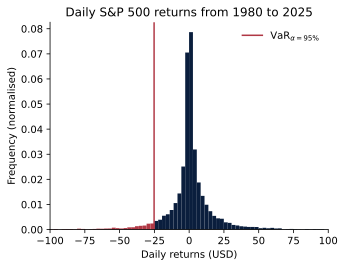

In [6]:
returns = raw.Close["^GSPC"].diff().dropna()

conf = .95
fig, ax = plt.subplots(figsize=(5,15/4))

var = np.quantile(returns, 1 - conf)
ax.axvline(var, color="#B03845", label=r"$\mathrm{VaR}_{\alpha=95\%}$")

_, bins, patches = ax.hist(returns, bins=200, density=True, color="#0A1E3D")
for patch, l_edge in zip(patches, bins[:-1]):
    if l_edge < var:
        patch.set_facecolor("#B03845")

plt.xlabel("Daily returns (USD)")
plt.ylabel("Frequency (normalised)")
plt.title("Daily S&P 500 returns from 1980 to 2025")

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(-100, 100)
plt.legend(frameon=False)

print("VaR: {:.2f}; VaR under normality: {:.2f}".format(var,
                                                        np.mean(returns) + np.std(returns) * scipy.stats.norm.ppf(.05)))

plt.show()

Expressed in English, from 1980 to 2025, the S&P 500 index had a 1-day 95% VaR of \$25.21; or there was a 95% probability that losses would not exceed \$25.21 in one day. This is quite different to the VaR under the normality assumption, which has a 1-day 95% VaR of \$32.21.

Although relatively easy to calculate, VaR is sensitive to the assumed underlying probability model: A light-tail distribution (e.g., the normal) used in place of a true fat-tailed distribution can lead to underestimation in VaR as $\alpha\to1$:

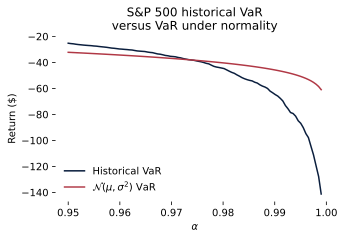

In [7]:
# <!-- collapse=True -->
def normalVaR(mu, sigma, conf):
    return mu + sigma * scipy.stats.norm.ppf(1-conf)

def normalCVaR(mu, sigma, conf):
    return mu - sigma * scipy.stats.norm.pdf(scipy.stats.norm.ppf(conf)) / (1-conf)
    
fig, ax = plt.subplots(figsize=(5,3))

confs = np.linspace(.95, .999, 100)
ax.plot(confs,
        [np.quantile(returns, 1 - conf) for conf in confs],
        color="#0A1E3D",
        label="Historical VaR")
ax.plot(confs,
        [normalVaR(np.mean(returns), np.std(returns), conf) for conf in confs],
        color="#B03845",
        label=r"$\mathcal{N}(\mu,\sigma^2)$ VaR")

ax.set_title("S&P 500 historical VaR\nversus VaR under normality")

ax.set_ylabel("Return ($)")
ax.set_xlabel(r"$\alpha$")
ax.spines[:].set_visible(False)
plt.legend(frameon=False)
plt.show()
# <end collapse>

## CVaR

The greatest drawback of VaR is the information lost by summarizing the tail of the distribution with just its upper value—VaR does not quantify the *shape* of the left tail. The *conditional* VaR (CVaR) or expected shortfall addresses this by calculating the average loss given the worst $(1-\alpha)\%$ of returns. In other words, it is the conditional expectation:
$$
\begin{align*}
\text{CVaR}_\alpha&=\mathbb{E}\left[X\mid X\le \text{VaR}_\alpha\right]\\
&= \frac{1}{1-\alpha}\int_{-\infty}^{\text{VaR}_\alpha} x\cdot f(x) dx,
\end{align*}
$$
where $f(\cdot)$ is the probability density function of $X$. Under the normality assumption, this simplifies to:
$$
\text{CVaR}_\alpha=\mu - \sigma\frac{\phi(F^{-1}(\alpha))}{1-\alpha},
$$


where $\phi(\cdot)$ is the probability density function of the standard normal.

CVaR is often considered an enhancement of VaR as it quantifies tail risk on top of answering the question of how often portfolio losses will exceed the worst $(1-\alpha)\%$ of cases. Reusing the same example above:

VaR: -25.21; VaR under normality: -32.21043951619077
CVaR: -50.47; CVaR under normality: -40.52311515074122


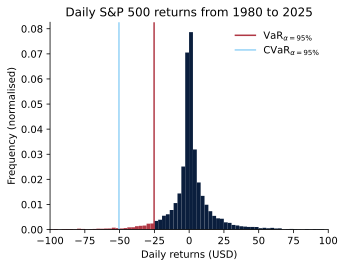

In [8]:
returns = raw.Close["^GSPC"].diff().dropna()

conf = .95
fig, ax = plt.subplots(figsize=(5,15/4))

var = np.quantile(returns, 1 - conf)
ax.axvline(var, color="#B03845", label=r"$\mathrm{VaR}_{\alpha=95\%}$")

_, bins, patches = ax.hist(returns, bins=200, density=True, color="#0A1E3D")
for patch, l_edge in zip(patches, bins[:-1]):
    if l_edge < var:
        patch.set_facecolor("#B03845")

cvar = np.mean(returns[returns <= var])
ax.axvline(cvar, color="#94D2F6", label=r"$\mathrm{CVaR}_{\alpha=95\%}$")

plt.xlabel("Daily returns (USD)")
plt.ylabel("Frequency (normalised)")
plt.title("Daily S&P 500 returns from 1980 to 2025")

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(-100, 100)
plt.legend(frameon=False)

print(f"VaR: {var:.2f}; VaR under normality: {normalVaR(np.mean(returns), np.std(returns), .95)}")
print(f"CVaR: {cvar:.2f}; CVaR under normality: {normalCVaR(np.mean(returns), np.std(returns), .95)}")

plt.show()

From 1980 to 2025, the S&P 500 index had a 1-day 95% CVaR of \$50.47, meaning that in the worst 5% of 1-day S&P 500 returns, the average loss would be \$50.47. This last example presents the common case where the CVaR under the normality assumption underestimates the true CVaR due to the presence of fat-tailed returns.



## References

- Daniel P Palomar (2024). Portfolio optimization. MSc in Financial Mathematics, HKUST, [Online]. Available: https://www.danielppalomar.com/mafs6010r---portfolio-optimization-with-r.html.
- Martin Haugh (2016). IEOR E4602 Quantitative Risk Management, Columbia University, [Online]. Available: http://www.columbia.edu/~mh2078/QuantRiskManagement.html
- Yue Shi, Chi Tim Ng, Ka-Fai Cedric Yiu (2018). Portfolio selection based on asymmetric Laplace distribution, coherent risk measure, and expectation-maximization estimation. Quantitative Finance and Economics.

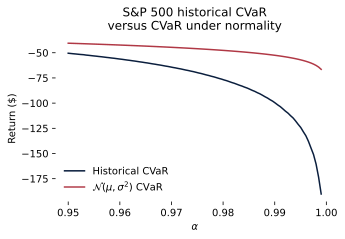

In [9]:
fig, ax = plt.subplots(figsize=(5,3))

confs = np.linspace(.95, .999, 100)
ax.plot(confs,
        [np.mean(returns[returns <= np.quantile(returns, 1 - conf)]) for conf in confs],
        color="#0A1E3D",
        label="Historical CVaR")
ax.plot(confs,
        [normalCVaR(np.mean(returns), np.std(returns), conf) for conf in confs],
        color="#B03845",
        label=r"$\mathcal{N}(\mu,\sigma^2)$ CVaR")

ax.set_title("S&P 500 historical CVaR\nversus CVaR under normality")

ax.set_ylabel("Return ($)")
ax.set_xlabel(r"$\alpha$")
ax.spines[:].set_visible(False)
plt.legend(frameon=False)
plt.show()  